In [1]:
import os   # for path operations
import datetime

import hyperas
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11543716755293133644
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9215183422
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10133259362675289835
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
patience=40
early_stopping=EarlyStopping(monitor = 'val_loss', patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="CNN_weights.hdf5", save_best_only=True, verbose =1)

In [4]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [5]:
def make_timeseries_instances(timeseries,window_size,nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    # nb_input defines the number of input time series that we use to predict outputs
    X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
    for coord in range(3):
        np.roll(X[:,coord+9],1) #move coordinates to the past
    np.delete(X,0,0)
    
    # We have 3 output signal: x, y and z position    
    y = timeseries[window_size:,-12:-9]
    np.delete(y,0,0)
    return X,y

In [6]:
def evalute_timeseries(timeseries, window_size, filter_length, nb_filter, epochs, batch_size):
    #timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    nb_inputs = nb_series - 9 #only 12 inputs (previous x,y,z position is an input now)
    #nb_outputs = nb_series - 12 #only 9 outputs
    nb_outputs=3
  
    #initialize model
    model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    #fill and split the input and output variables
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    valid_size = int(0.2 * nb_samples)
    X_train, X_valid, X_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    """
    # Standardize input variables for train, valid and test data
    for inpt in range(X.shape[1]):
        scaler = preprocessing.StandardScaler().fit(X_train[:,inpt])
        X_train[:,inpt] = scaler.transform(X_train[:,inpt])
        X_valid[:,inpt] = scaler.transform(X_valid[:,inpt])
        X_test[:,inpt] = scaler.transform(X_test[:,inpt])
    """
    
    #train model
    model.fit(X_train,y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, y_valid),
              verbose = 2, callbacks = [checkpointer,early_stopping])
  
    #load the best model for plotting
    bestmodel = load_model("CNN_weights.hdf5")
    preds = bestmodel.predict(X_test)
    targets = y_test
    
    print(preds.shape)
    print(targets.shape)
    
    # Plot predicted x vs target x
    plt.figure(0)
    plt.plot(preds[:,0],color='green')
    plt.plot(targets[:,0],color='red')
    
    # Plot predicted z vs target z
    plt.figure(1)
    plt.plot(preds[:,2],color='blue')
    plt.plot(targets[:,2],color='yellow')
    
    # Plot the predicted route vs original route on x-z plane
    plt.figure(2)
    plt.plot(preds[:,0],preds[:,2])
    plt.plot(targets[:,0],targets[:,2])

In [7]:
def data(timeseries): 
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    nb_inputs = nb_series - 8 #only 12 inputs (previous x,y,z position is an input now)
    window_size = 20
    
    #fill and split the input and output variables
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.15  * nb_samples)
    valid_size = int(0.15 * nb_samples)
    
    x_train, x_valid, x_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Standardize input variables for train, valid and test data
    for inpt in range(X.shape[1]):
        scaler = preprocessing.StandardScaler().fit(x_train[:,inpt])
        x_train[:,inpt] = scaler.transform(x_train[:,inpt])
        x_valid[:,inpt] = scaler.transform(x_valid[:,inpt])
        x_test[:,inpt] = scaler.transform(x_test[:,inpt])
        
    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [8]:
def create_model(x_train, y_train, x_valid, y_valid, x_test, y_test):
    n_layer1 = {{choice([128, 256, 512])}}
    n_layer2 = {{choice([128, 256, 512])}}
    optim = {{choice(['rmsprop', 'adam', 'sgd'])}}
    n_batch = {{choice([16, 31, 64])}}
    
    window_size = 20
    filter_length = 5
    nb_outputs=3
    
    model = Sequential()
    model.add(Conv1D(filters=n_layer1, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=n_layer2, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation='linear'))
    model.compile(loss='mse', optimizer= optim, metrics=['mae'])
    
    result = model.fit(x_train, y_train,
              batch_size=n_batch,
              epochs=150,
              verbose=2,
              validation_data=(x_valid, y_valid),
              callbacks=[checkpointer,early_stopping],
              shuffle=True)
    
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [9]:
df = pd.read_csv('Bazs\\PreprocessedData_v2.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [10]:
df.head(2)

acc0    acc1    acc2   gyro0   gyro1   gyro2    mag0    mag1    mag2  \
0 -0.0029  0.0003 -0.0003 -0.0194  0.0124 -0.0022 -0.5292 -0.6538 -0.5275   
1 -0.0029  0.0013  0.0007 -0.0085  0.0023  0.0006 -0.5292 -0.6538 -0.4945   

       x   ...         z    beta     Qx    Qy     Qz   Qw  delta_t  delta_x  \
0 -0.582   ...     0.402 -0.0129  0.005  0.02  0.000  1.0   0.0000      0.0   
1 -0.582   ...     0.402 -0.0128  0.005  0.02  0.001  1.0   0.0891      0.0   

   delta_y  delta_z  
0      0.0      0.0  
1      0.0      0.0  

[2 rows x 21 columns]

In [11]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 500
batch_size = 16
validation_split = 0.2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 16, 4)             244       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 355
Trainable params: 355
Non-trainable params: 0
_________________________________________________________________
Train on 382

 - 1s - loss: 2.9240e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0013 - val_mean_absolute_error: 0.0241

Epoch 00039: val_loss did not improve from 0.00117
Epoch 40/500
 - 1s - loss: 3.0031e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0011 - val_mean_absolute_error: 0.0229

Epoch 00040: val_loss improved from 0.00117 to 0.00107, saving model to CNN_weights.hdf5
Epoch 41/500
 - 1s - loss: 2.8205e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0015 - val_mean_absolute_error: 0.0260

Epoch 00041: val_loss did not improve from 0.00107
Epoch 42/500
 - 1s - loss: 2.8032e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0014 - val_mean_absolute_error: 0.0261

Epoch 00042: val_loss did not improve from 0.00107
Epoch 43/500
 - 1s - loss: 2.7723e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0015 - val_mean_absolute_error: 0.0252

Epoch 00043: val_loss did not improve from 0.00107
Epoch 44/500
 - 1s - loss: 2.7706e-04 - mean_absolute_error: 0.0117 - val_loss: 8.2959e-04 - val_mean_absolute


Epoch 00083: val_loss did not improve from 0.00048
Epoch 84/500
 - 1s - loss: 1.6070e-04 - mean_absolute_error: 0.0084 - val_loss: 5.1053e-04 - val_mean_absolute_error: 0.0153

Epoch 00084: val_loss did not improve from 0.00048
Epoch 85/500
 - 1s - loss: 1.7603e-04 - mean_absolute_error: 0.0088 - val_loss: 5.8239e-04 - val_mean_absolute_error: 0.0151

Epoch 00085: val_loss did not improve from 0.00048
Epoch 86/500
 - 1s - loss: 1.8183e-04 - mean_absolute_error: 0.0089 - val_loss: 8.9476e-04 - val_mean_absolute_error: 0.0197

Epoch 00086: val_loss did not improve from 0.00048
Epoch 87/500
 - 1s - loss: 1.7420e-04 - mean_absolute_error: 0.0088 - val_loss: 8.9774e-04 - val_mean_absolute_error: 0.0196

Epoch 00087: val_loss did not improve from 0.00048
Epoch 88/500
 - 1s - loss: 1.6697e-04 - mean_absolute_error: 0.0086 - val_loss: 4.5073e-04 - val_mean_absolute_error: 0.0146

Epoch 00088: val_loss improved from 0.00048 to 0.00045, saving model to CNN_weights.hdf5
Epoch 89/500
 - 1s - loss


Epoch 00128: val_loss did not improve from 0.00021
Epoch 129/500
 - 1s - loss: 1.2399e-04 - mean_absolute_error: 0.0072 - val_loss: 3.2065e-04 - val_mean_absolute_error: 0.0120

Epoch 00129: val_loss did not improve from 0.00021
Epoch 130/500
 - 1s - loss: 1.2505e-04 - mean_absolute_error: 0.0072 - val_loss: 2.2673e-04 - val_mean_absolute_error: 0.0103

Epoch 00130: val_loss did not improve from 0.00021
Epoch 131/500
 - 1s - loss: 1.1954e-04 - mean_absolute_error: 0.0070 - val_loss: 2.9250e-04 - val_mean_absolute_error: 0.0124

Epoch 00131: val_loss did not improve from 0.00021
Epoch 132/500
 - 1s - loss: 1.2183e-04 - mean_absolute_error: 0.0071 - val_loss: 2.1222e-04 - val_mean_absolute_error: 0.0098

Epoch 00132: val_loss did not improve from 0.00021
Epoch 133/500
 - 1s - loss: 1.2439e-04 - mean_absolute_error: 0.0072 - val_loss: 2.6814e-04 - val_mean_absolute_error: 0.0117

Epoch 00133: val_loss did not improve from 0.00021
Epoch 134/500
 - 1s - loss: 1.2977e-04 - mean_absolute_err

 - 1s - loss: 9.5126e-05 - mean_absolute_error: 0.0062 - val_loss: 2.0981e-04 - val_mean_absolute_error: 0.0104

Epoch 00174: val_loss did not improve from 0.00013
Epoch 175/500
 - 1s - loss: 8.2362e-05 - mean_absolute_error: 0.0057 - val_loss: 1.7171e-04 - val_mean_absolute_error: 0.0097

Epoch 00175: val_loss did not improve from 0.00013
Epoch 176/500
 - 1s - loss: 9.1107e-05 - mean_absolute_error: 0.0061 - val_loss: 1.9966e-04 - val_mean_absolute_error: 0.0100

Epoch 00176: val_loss did not improve from 0.00013
Epoch 177/500
 - 1s - loss: 8.3676e-05 - mean_absolute_error: 0.0058 - val_loss: 2.3991e-04 - val_mean_absolute_error: 0.0115

Epoch 00177: val_loss did not improve from 0.00013
Epoch 178/500
 - 1s - loss: 1.0373e-04 - mean_absolute_error: 0.0064 - val_loss: 1.5394e-04 - val_mean_absolute_error: 0.0088

Epoch 00178: val_loss did not improve from 0.00013
Epoch 179/500
 - 1s - loss: 8.7032e-05 - mean_absolute_error: 0.0059 - val_loss: 2.5932e-04 - val_mean_absolute_error: 0.011

 - 1s - loss: 7.3795e-05 - mean_absolute_error: 0.0053 - val_loss: 8.0445e-05 - val_mean_absolute_error: 0.0066

Epoch 00220: val_loss improved from 0.00010 to 0.00008, saving model to CNN_weights.hdf5
Epoch 221/500
 - 1s - loss: 7.4848e-05 - mean_absolute_error: 0.0055 - val_loss: 1.2108e-04 - val_mean_absolute_error: 0.0082

Epoch 00221: val_loss did not improve from 0.00008
Epoch 222/500
 - 1s - loss: 6.5405e-05 - mean_absolute_error: 0.0051 - val_loss: 1.2893e-04 - val_mean_absolute_error: 0.0080

Epoch 00222: val_loss did not improve from 0.00008
Epoch 223/500
 - 1s - loss: 6.8573e-05 - mean_absolute_error: 0.0051 - val_loss: 1.3773e-04 - val_mean_absolute_error: 0.0087

Epoch 00223: val_loss did not improve from 0.00008
Epoch 224/500
 - 1s - loss: 6.1876e-05 - mean_absolute_error: 0.0049 - val_loss: 1.3611e-04 - val_mean_absolute_error: 0.0084

Epoch 00224: val_loss did not improve from 0.00008
Epoch 225/500
 - 1s - loss: 7.5584e-05 - mean_absolute_error: 0.0055 - val_loss: 8.660


Epoch 00265: val_loss did not improve from 0.00007
Epoch 266/500
 - 1s - loss: 5.6549e-05 - mean_absolute_error: 0.0047 - val_loss: 1.2840e-04 - val_mean_absolute_error: 0.0076

Epoch 00266: val_loss did not improve from 0.00007
Epoch 267/500
 - 1s - loss: 6.2699e-05 - mean_absolute_error: 0.0049 - val_loss: 5.9797e-05 - val_mean_absolute_error: 0.0056

Epoch 00267: val_loss improved from 0.00007 to 0.00006, saving model to CNN_weights.hdf5
Epoch 268/500
 - 1s - loss: 6.1796e-05 - mean_absolute_error: 0.0049 - val_loss: 9.9523e-05 - val_mean_absolute_error: 0.0075

Epoch 00268: val_loss did not improve from 0.00006
Epoch 269/500
 - 1s - loss: 5.5598e-05 - mean_absolute_error: 0.0046 - val_loss: 1.5339e-04 - val_mean_absolute_error: 0.0091

Epoch 00269: val_loss did not improve from 0.00006
Epoch 270/500
 - 1s - loss: 6.1749e-05 - mean_absolute_error: 0.0048 - val_loss: 9.4120e-05 - val_mean_absolute_error: 0.0068

Epoch 00270: val_loss did not improve from 0.00006
Epoch 271/500
 - 1s 


Epoch 00311: val_loss did not improve from 0.00006
Epoch 312/500
 - 1s - loss: 5.1254e-05 - mean_absolute_error: 0.0045 - val_loss: 9.6256e-05 - val_mean_absolute_error: 0.0069

Epoch 00312: val_loss did not improve from 0.00006
Epoch 313/500
 - 1s - loss: 5.7209e-05 - mean_absolute_error: 0.0047 - val_loss: 8.1699e-05 - val_mean_absolute_error: 0.0065

Epoch 00313: val_loss did not improve from 0.00006
Epoch 314/500
 - 1s - loss: 6.0009e-05 - mean_absolute_error: 0.0049 - val_loss: 2.1330e-04 - val_mean_absolute_error: 0.0110

Epoch 00314: val_loss did not improve from 0.00006
Epoch 315/500
 - 1s - loss: 5.2427e-05 - mean_absolute_error: 0.0045 - val_loss: 1.2618e-04 - val_mean_absolute_error: 0.0081

Epoch 00315: val_loss did not improve from 0.00006
Epoch 316/500
 - 1s - loss: 5.5462e-05 - mean_absolute_error: 0.0047 - val_loss: 1.4431e-04 - val_mean_absolute_error: 0.0085

Epoch 00316: val_loss did not improve from 0.00006
Epoch 317/500
 - 1s - loss: 5.2805e-05 - mean_absolute_err

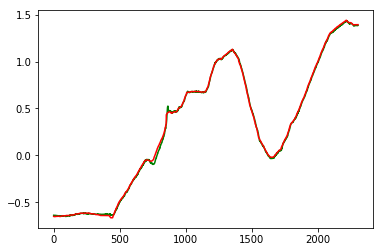

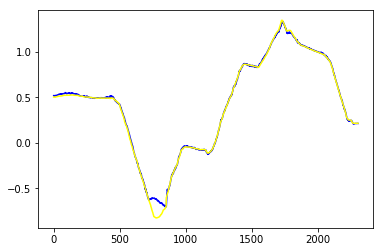

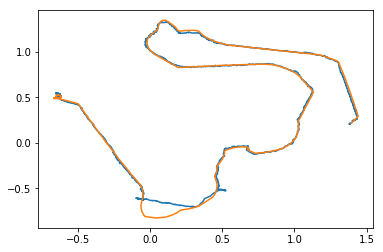

In [13]:
evalute_timeseries(df,window_size,filter_length,nb_filter, epochs, batch_size)

In [ ]:
plt.plot(df_arr[:,-12],df_arr[:,-10])

In [ ]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# main hyperopt part
# az algoritmus lehet:
# -- random.suggest -> random search
# -- tpe.suggest -> tree parsen estimator
best_run, best_model = optim.minimize(model=create_model,
                                          data=data(timeData),
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                        notebook_name='CNN_Mark')
#x_train, y_train, x_valid, y_valid, x_test, y_test = data(timeData)
#print("Evalutation of best performing model:")
#print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
